In [1]:
from qiskit.opflow import X, Y, Z, I, PauliTrotterEvolution, MatrixEvolution
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, execute
from qiskit import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.compiler import transpile
from qiskit.circuit.add_control import add_control
from qiskit.extensions import UnitaryGate

import scipy
import warnings
import numpy as np
from scipy.linalg import expm
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

#### Hamiltonian time evolution simulation

$$ \hat{H} = \frac{1}{2} \left( \hat{\sigma}_y \otimes \hat{\sigma}_y \otimes \hat{\sigma}_x +  \hat{\sigma}_x \otimes \hat{\sigma}_y \otimes \hat{\sigma}_z + \hat{\sigma}_z \otimes \hat{\sigma}_y \otimes \hat{\sigma}_x + \hat{\sigma}_z \otimes \hat{\sigma}_x \otimes \hat{\sigma}_y \right) $$

In [2]:
operator_H = ((Y ^ Y ^ X) + (X ^ Y ^ Z) + (Z ^ Y ^ X) + (Z ^ X ^ Y))*1/2

print(operator_H)

0.5 * YYX
+ 0.5 * XYZ
+ 0.5 * ZYX
+ 0.5 * ZXY


In [3]:
H = operator_H.to_matrix()

In [4]:
H.shape

(8, 8)

$
\newcommand\bra[2][]{#1\langle {#2} #1\rvert}
\newcommand\ket[2][]{#1\lvert {#2} #1\rangle}
$
<center><b style="font-size: large;">Schrödinger equation</b></center><br/>
$$ \displaystyle \frac{d}{d t}\ket{\psi(t)}  = \ket{\psi}e^{-iHt} $$

In [5]:
def psi(t,psi0,H):
    lpsi = len(psi0)
    lH = H.shape[0]
    assert lpsi == lH
    
    psi0ket = np.array(psi0).reshape(lpsi,1)
    psitket = np.dot(expm(- 1j*t*H),psi0ket)
    return psitket

In [6]:
'initial state |psi(0)>'
psi0 = np.zeros((1, H.shape[1]))
psi0[0][0] = 1
psi0 = psi0.flatten().tolist()

In [7]:
tend = 10
steps = 100
tlist= np.linspace(0,tend, steps + 1)

'state at time t |psi(t)>'
psitketlist = [psi(tlist[i],psi0,H) for i in range(len(tlist))]

In [8]:
'probs'
p00list = [np.abs(psitketlist[i][0,0])  for i in range(len(tlist))]
p01list = [np.abs(psitketlist[i][1,0])  for i in range(len(tlist))]

<center><b style="font-size: large;">Expected value</b></center><br/>
$$\langle H(t) \rangle=\bra{\psi}H(t) \ket{\psi} $$

In [9]:
'expected values <H>(t)'
psitbralist= [psitketlist[i].conj().T for i in range(len(tlist))]
Hvevtlist = [np.dot(psitbralist[i],np.dot(H,psitketlist[i])).real[0,0] for i in range(len(tlist))]

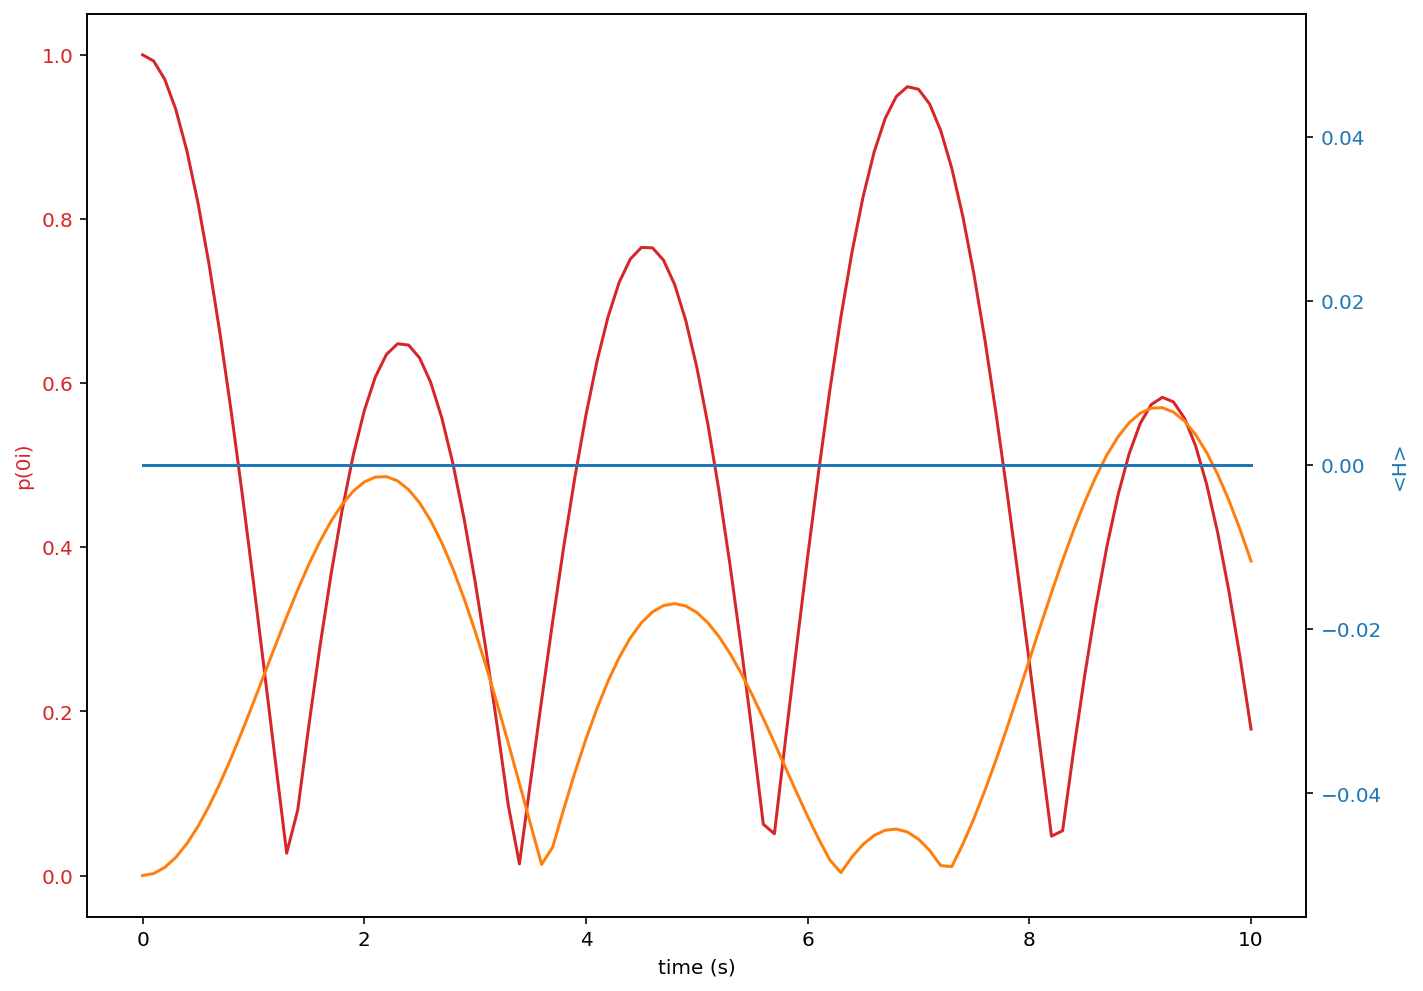

In [10]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('p(0i)', color= 'tab:red')
ax1.plot(tlist,p00list, color= 'tab:red')
ax1.plot(tlist,p01list, color= 'tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('<H>', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(tlist,Hvevtlist, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Hamiltonian evolution w/Qiskit

In [11]:
t = Parameter('t')

time_H = (t * operator_H).exp_i()

In [12]:
print(time_H)

e^(-i*1.0*t * (
  0.5 * YYX
  + 0.5 * XYZ
  + 0.5 * ZYX
  + 0.5 * ZXY
))


In [13]:
evolution_time = 2

mat_evo = MatrixEvolution()

result_mat_exp = mat_evo.convert(time_H)
result_mat_exp = result_mat_exp.bind_parameters({t: evolution_time})

#print(result_mat_exp.to_matrix())
print(result_mat_exp)

Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.


     ┌──────────────┐
q_0: ┤0             ├
     │              │
q_1: ┤1 Hamiltonian ├
     │              │
q_2: ┤2             ├
     └──────────────┘


In [14]:
# Set number of qubits
num_qubits = 3

# Define time parameter
t = Parameter('t')

# Set total evolution time
evolution_time_t = 2

# Set size of time-step for Trotter evolution
time_step_value_t = 0.1

# Define the number of steps
steps_t = int(evolution_time_t/time_step_value_t)

# Create circuit
tight_binding_circuit = QuantumCircuit(num_qubits)

# Add initial state preparation
tight_binding_circuit.x(0)

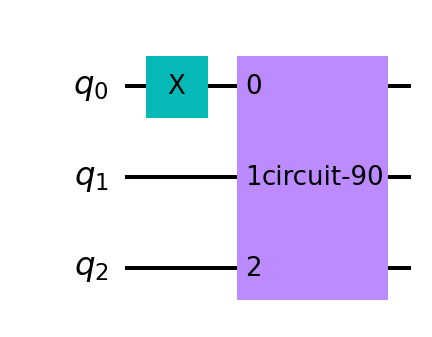

In [15]:
# Define the Hamiltonian, the time-evolution operator, the Trotter step and the total evolution

H1 = (I ^ X ^ X) + (X ^ X ^ I) + (I ^ Y ^ Y) + (Y ^ Y ^ I)

time_H1 = (t*H1).exp_i()

ptrot = PauliTrotterEvolution()
trot_exp_circ = ptrot.convert(time_H1)
trot_exp_circ = trot_exp_circ.bind_parameters({t: time_step_value_t})

trot_final_x = trot_exp_circ

for _ in list(range(steps_t - 1)):
    trot_final_x @= trot_exp_circ

temp_circ = QuantumCircuit(3)
temp_circ.append(trot_final_x, [0,1,2])

instruc = temp_circ.to_instruction()

full_time_evolution_circuit = tight_binding_circuit.compose(instruc, [0,1,2])

full_time_evolution_circuit.draw(output='mpl')

In [16]:
backend = Aer.get_backend('statevector_simulator')

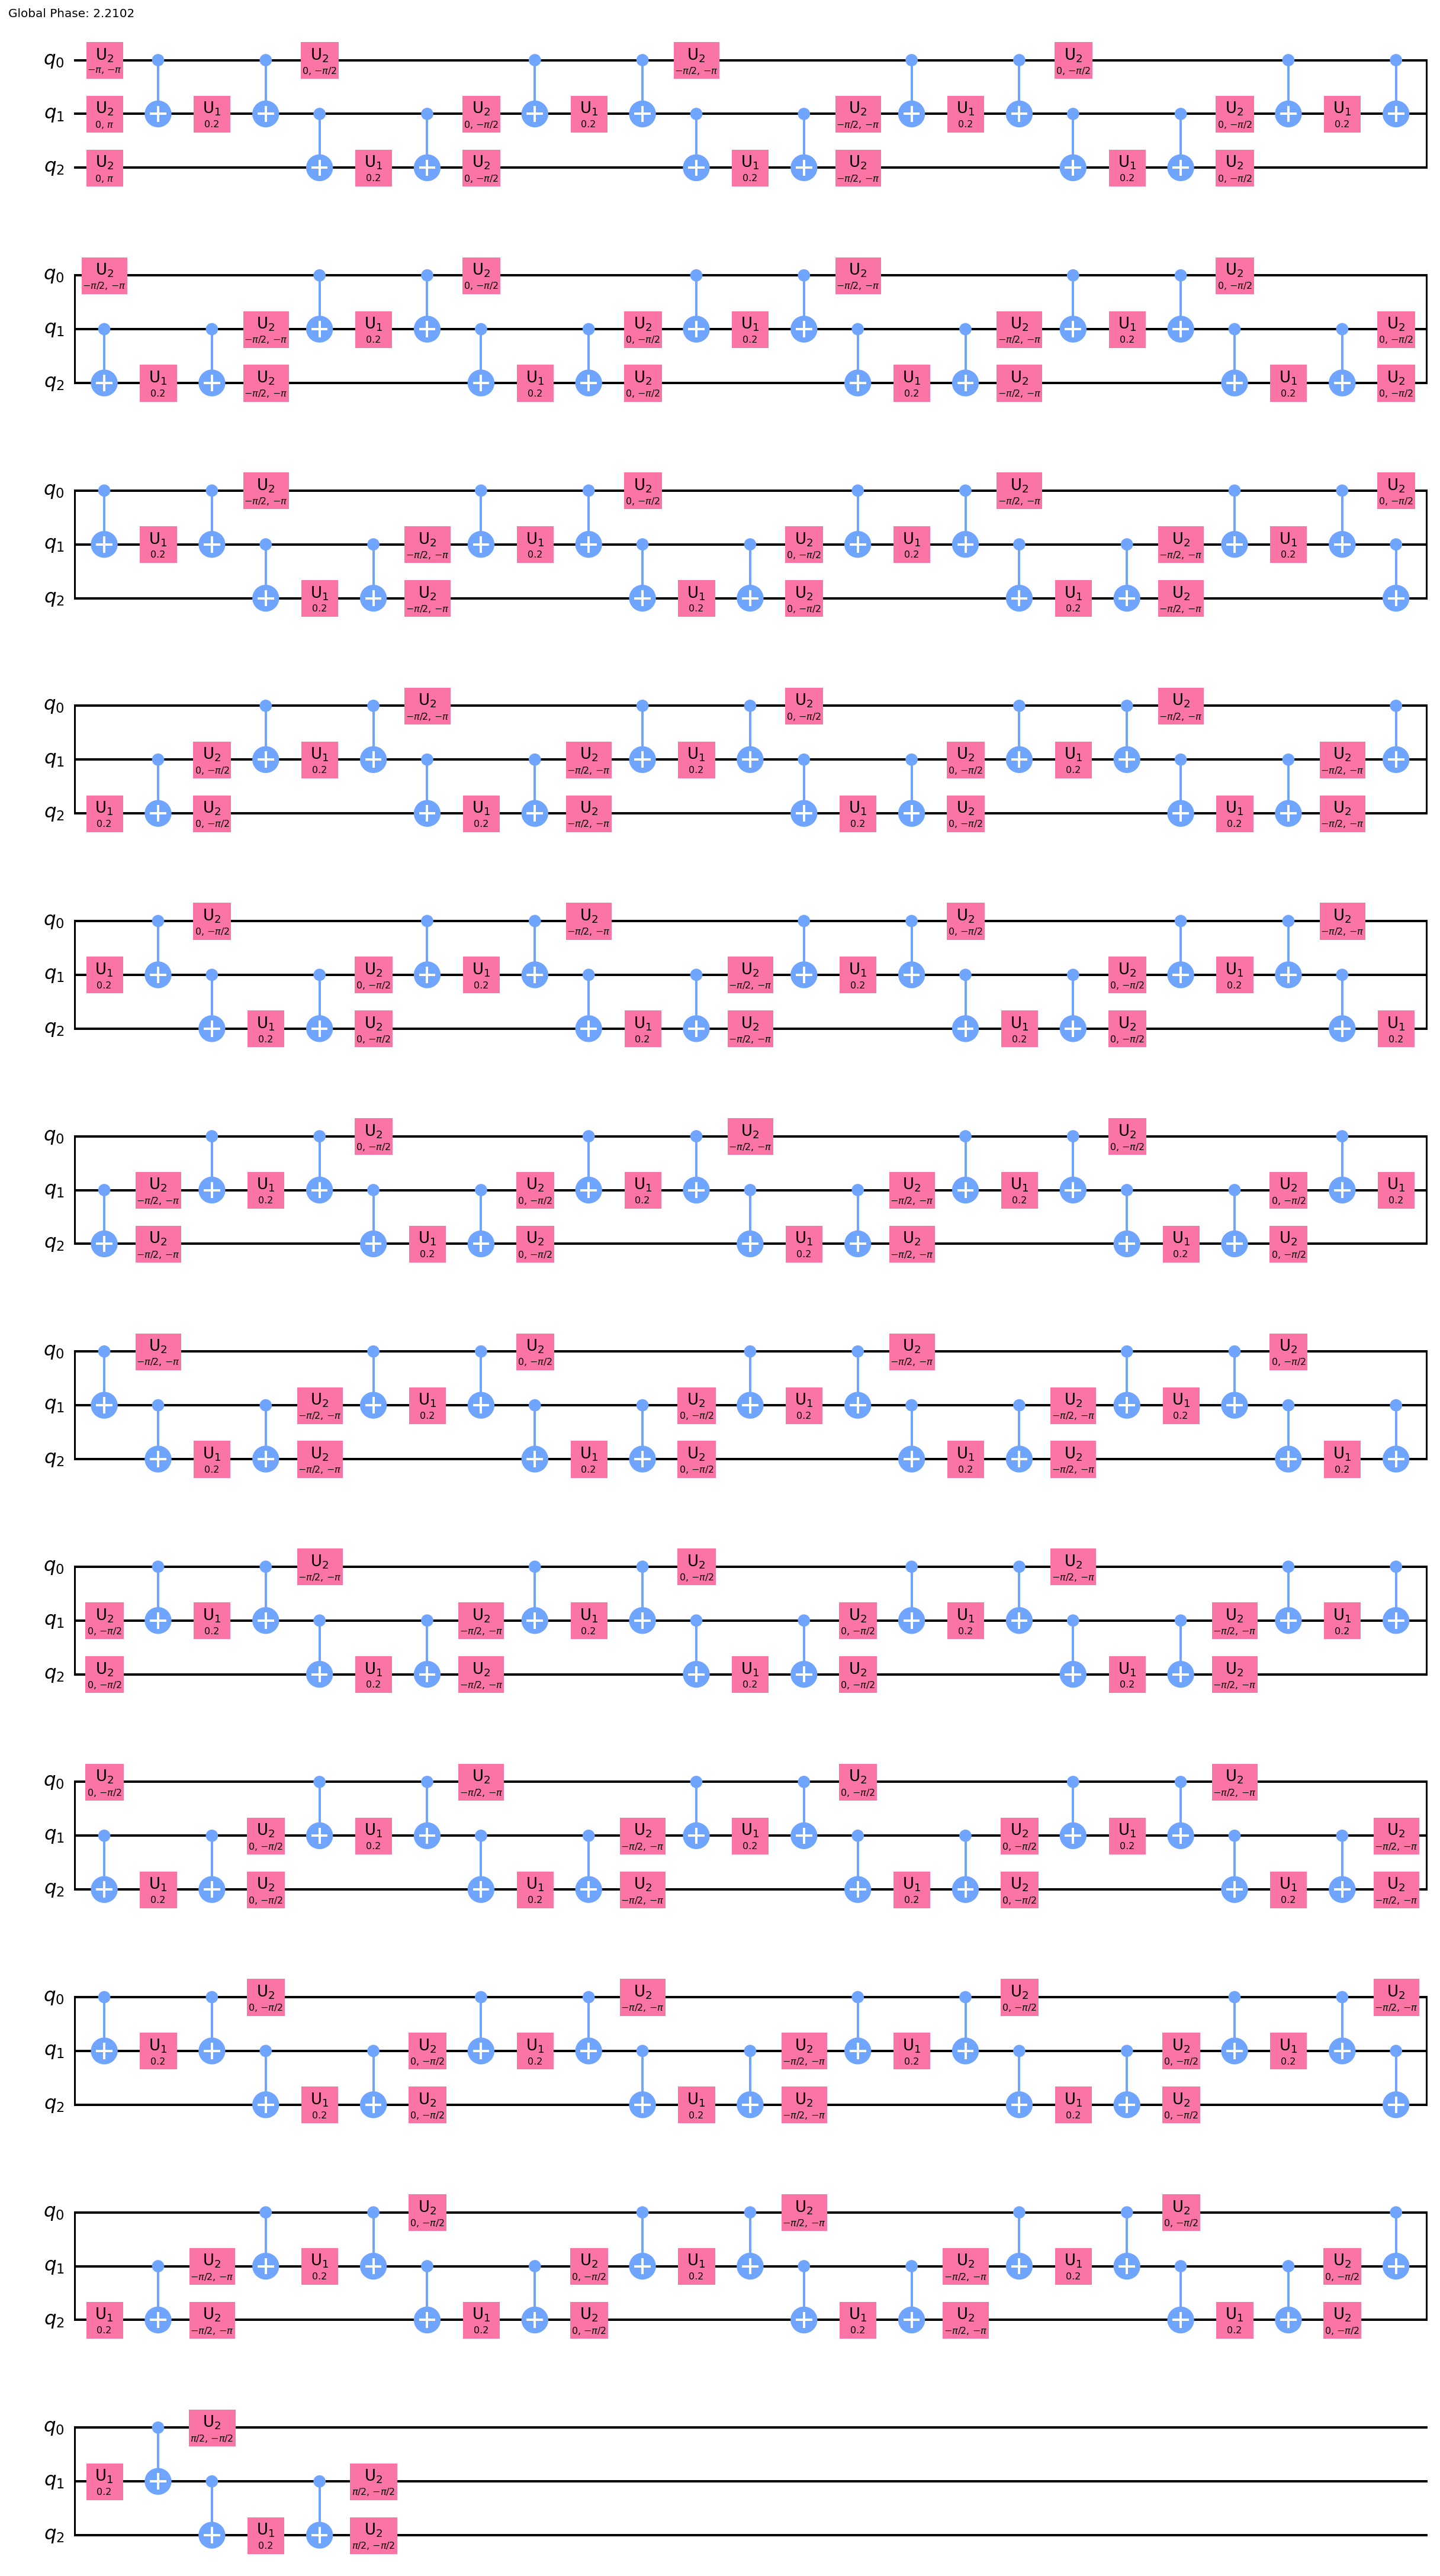

In [17]:
transpiled_circ = transpile(full_time_evolution_circuit, 
                            backend=backend, basis_gates=['u1', 'u2', 'u3', 'cx'], 
                            optimization_level=1)

transpiled_circ.draw(output='mpl')

In [18]:
result = execute(full_time_evolution_circuit, backend).result()

counts = result.get_counts(full_time_evolution_circuit)

state = result.get_statevector(full_time_evolution_circuit)

In [19]:
print("Circuit State = " + str(state))

Circuit State = Statevector([ 0.        +0.j        ,  0.90418552+0.j        ,
              0.        +0.41614385j,  0.        +0.j        ,
             -0.09581448+0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        -0.00961351j],
            dims=(2, 2, 2))


In [20]:
np.array(state)

array([ 0.        +0.j        ,  0.90418552+0.j        ,
        0.        +0.41614385j,  0.        +0.j        ,
       -0.09581448+0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        -0.00961351j])

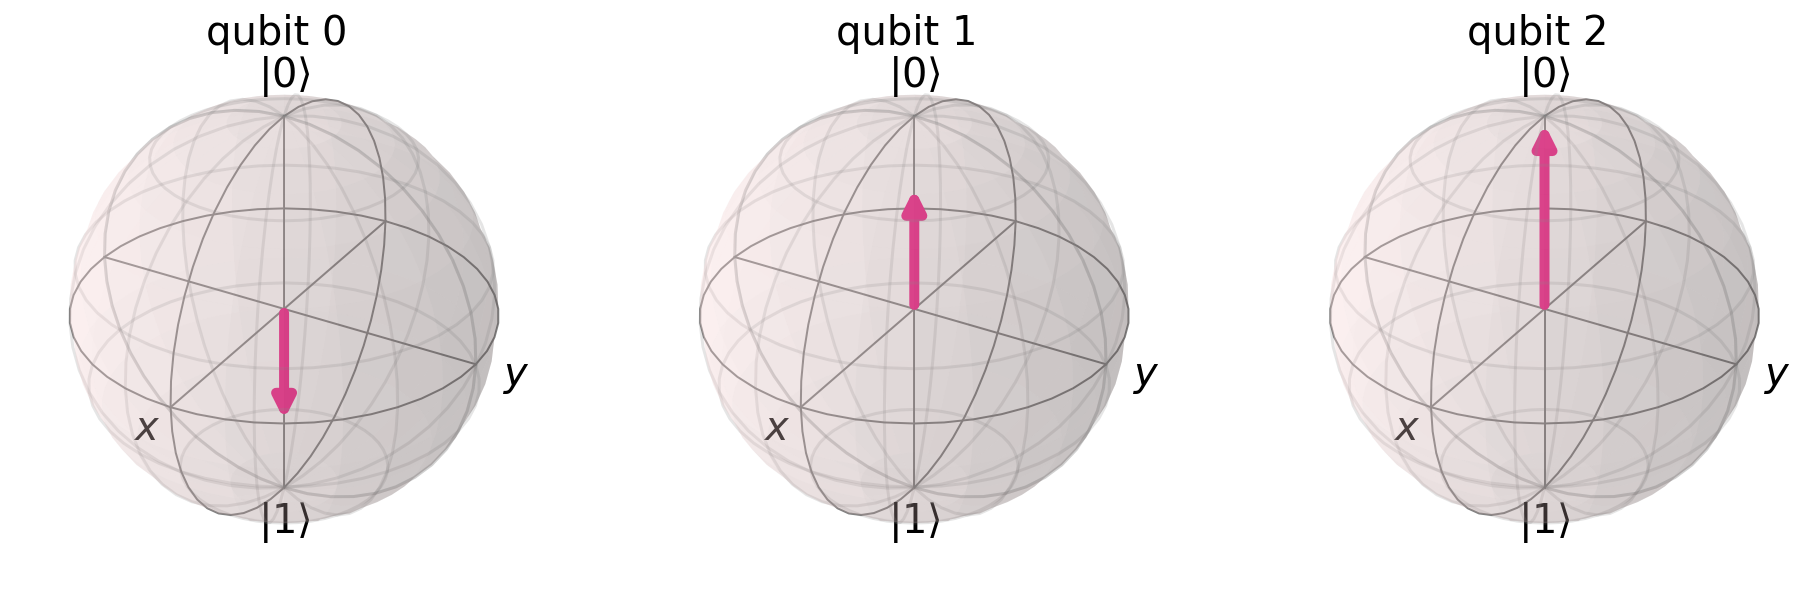

In [21]:
plot_bloch_multivector(state)

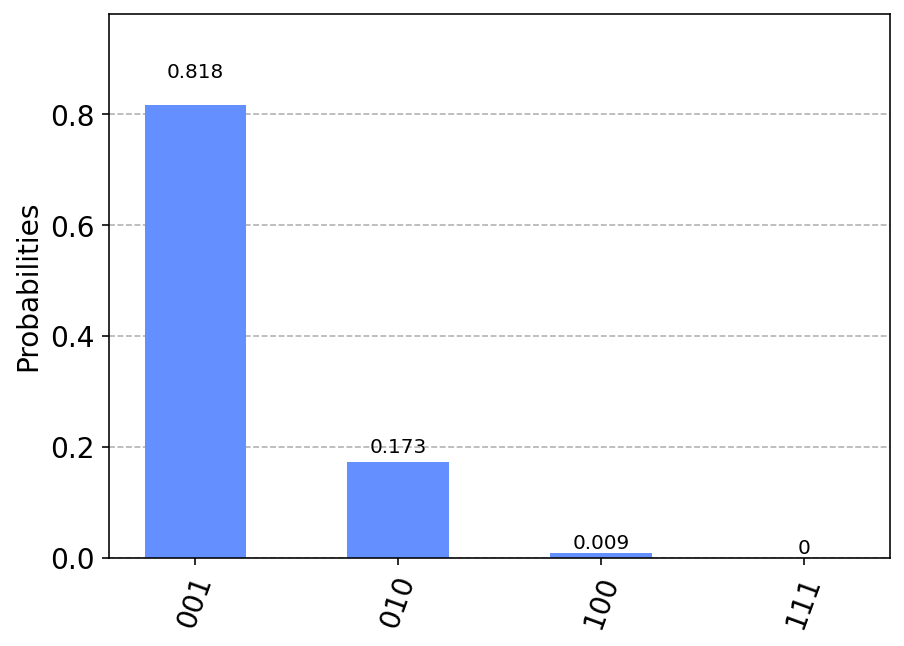

In [22]:
plot_histogram(counts)

### Unitary array to gate

In [23]:
unitary_4x4 = np.array([[0, 1, 0, 0], [1, 0, 0, 0], 
                        [0, 0, 0, 1], [0, 0, 1, 0]])

In [24]:
def create_control_gate(gate_arr):
    
    size = len(gate_arr)
    
    # This makes a controlled variant of the matrix
    c_gate = np.vstack([np.hstack([np.eye(size), np.zeros((size, size))]),
                        np.hstack([np.zeros((size, size)), gate_arr])])
    
    return c_gate

In [25]:
# U^-1 = U^dagger
scipy.linalg.inv(unitary_4x4) == unitary_4x4.conj().T

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [26]:
cgate = create_control_gate(unitary_4x4)
cgate

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [68]:
from qiskit.visualization import array_to_latex

array_to_latex(cgate, prefix = "C-Unitary = ", precision=0, max_size=cgate.shape)

<IPython.core.display.Latex object>

In [28]:
# U^-1 = U^dagger
scipy.linalg.inv(cgate) == cgate.conj().T

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

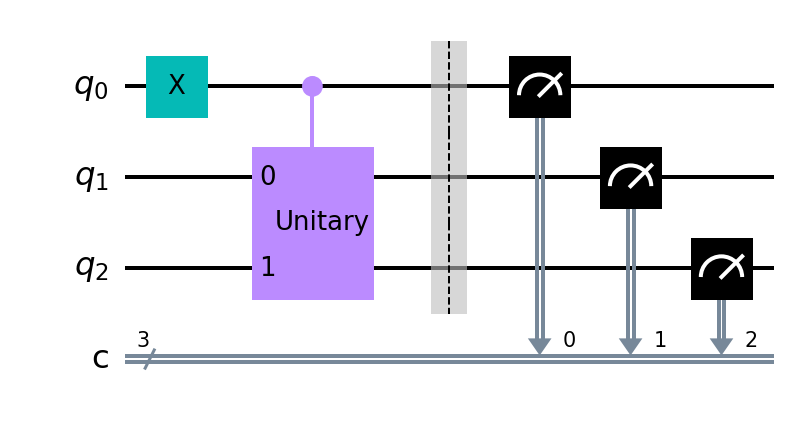

In [53]:
qc = QuantumCircuit(3,3)

qc.x(0)

#gate4x4 = UnitaryGate(cgate)
#qc.unitary(gate4x4, [1,2,0])

gate4x4 = UnitaryGate(unitary_4x4)
gate4x4_ctrl = add_control(gate4x4, 1, "", 1)
qc.append(gate4x4_ctrl, [0,1,2])

qc.barrier()
qc.measure(range(3), range(3))

qc.draw('mpl')

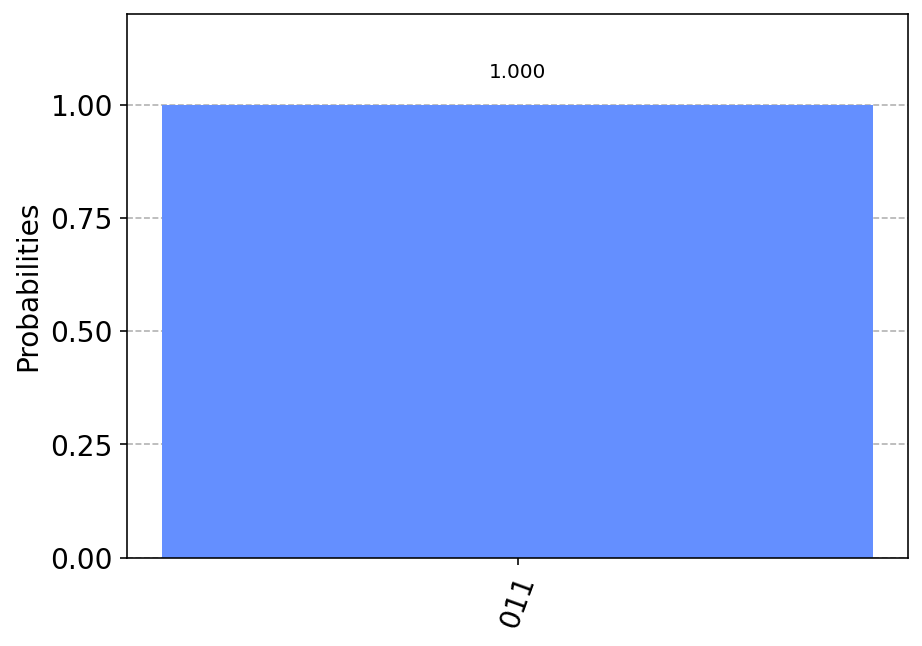

In [54]:
backend = Aer.get_backend('qasm_simulator')

results = execute(qc, backend=backend, shots=2048).result()
counts = results.get_counts()

plot_histogram(counts)

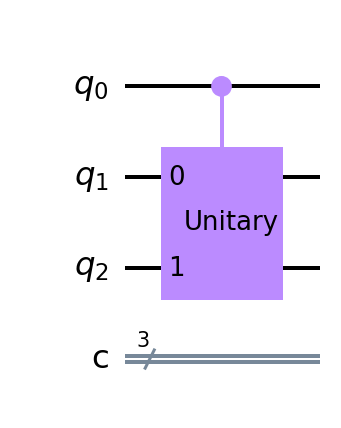

In [75]:
qc_simple = QuantumCircuit(3,3)

#gate4x4 = UnitaryGate(cgate)
#qc_simple.unitary(gate4x4, [1,2,0])

gate4x4 = UnitaryGate(unitary_4x4)
gate4x4_ctrl = add_control(gate4x4, 1, "", 1)
qc_simple.append(gate4x4_ctrl, [0,1,2])

#qc_simple.barrier()
#qc_simple.measure(range(3), range(3))

qc_simple.draw('mpl')

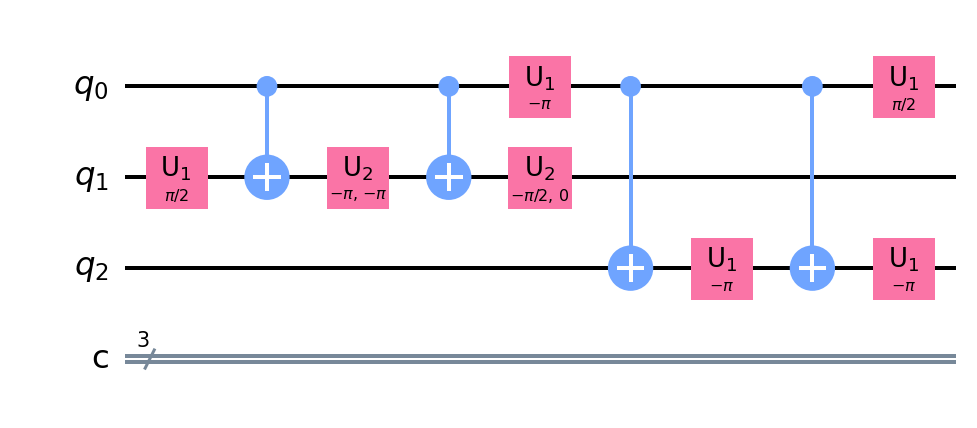

In [76]:
# Circuit transpilation to obtain the unitary matrix
transpiled_circ_unitary = transpile(qc_simple, 
                                    backend=backend, basis_gates=['u1', 'u2', 'u3', 'cx'], 
                                    optimization_level=1)

transpiled_circ_unitary.draw(output='mpl')

In [77]:
backend = Aer.get_backend('unitary_simulator')

result = execute(transpiled_circ_unitary, backend, shots=2048).result()
unitary = result.get_unitary(transpiled_circ_unitary, decimals=3)

arr_unitary = np.array(unitary)
array_to_latex(arr_unitary, prefix = "C-Unitary = ", precision=0, max_size=arr_unitary.shape)

<IPython.core.display.Latex object>